In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import pickle
from sklearn.preprocessing import StandardScaler
import patsy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



### Part 1: Data Cleaning, Preparing, and Exploring

For data cleaning, I decided to break departure time into parts of the day to avoid overfitting. I also excluded arrival time and schedule elapsed time. Arrival time is highly correlated with departure delay and scheduled elapsed time is highly correlated with distance so including would only cause information redundancy. In addition, I tried to include scheduled elapsed time into my model and it actually decreased the recall and precision of the model by a couple of points so as a result I excluded it from my analysis.  As for arrival time, I think it does not make sense to include it since we trying to predict cancelations. 

In [2]:
# Loading data 
data=pd.read_csv('FlightDelays_Data_3.0.csv')

In [3]:
# Looking at the data and its type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
Canceled            5999 non-null float64
Month               6000 non-null int64
DepartureTime       6000 non-null int64
UniqueCarrier       6000 non-null object
SchedElapsedTime    5998 non-null float64
ArrDelay            5999 non-null float64
DepDelay            6000 non-null int64
Distance            5999 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 375.1+ KB


In [4]:
# Summary statistics of the data
data.describe()

,Canceled,Month,DepartureTime,SchedElapsedTime,ArrDelay,DepDelay,Distance
count,5999.000,6000.000,6000.000,5998.000,5999.000,6000.000,5999.000
mean,0.167,6.220,1330.466,161.607,8.108,9.149,991.191
std,0.373,3.436,459.118,78.155,35.764,31.669,685.685
min,0.000,1.000,5.000,-127.000,-72.000,-16.000,-439.000
25%,0.000,3.000,930.000,105.000,-8.000,-3.000,547.000
50%,0.000,6.000,1325.000,145.000,0.000,0.000,837.000
75%,0.000,9.000,1715.000,200.000,10.000,6.000,1249.000
max,1.000,12.000,2359.000,604.000,410.000,387.000,15990.000


In [5]:
# Looking whether my data is correlated
data.corr()

,Canceled,Month,DepartureTime,SchedElapsedTime,ArrDelay,DepDelay,Distance
Canceled,1.000,-0.135,0.012,-0.071,-0.101,-0.128,-0.073
Month,-0.135,1.000,-0.009,-0.020,-0.024,-0.015,-0.017
DepartureTime,0.012,-0.009,1.000,-0.017,0.108,0.137,-0.016
SchedElapsedTime,-0.071,-0.020,-0.017,1.000,0.009,0.032,0.931
ArrDelay,-0.101,-0.024,0.108,0.009,1.000,0.896,0.007
DepDelay,-0.128,-0.015,0.137,0.032,0.896,1.000,0.028
Distance,-0.073,-0.017,-0.016,0.931,0.007,0.028,1.000


In [6]:
# Number of airlines in the data set
data['UniqueCarrier'].value_counts()

AA    2476
UA    1836
DL    1688
Name: UniqueCarrier, dtype: int64

In [7]:
# Adjusting time (converting into 4 digits string) to convert it into day parts
def adjust_time(time):
    if len(str(time))==2:return '24'+str(time)
    elif len(str(time))==3:return '0'+str(time)
    else: return str(time)
data['DepartureTime']=data['DepartureTime'].map(adjust_time)
# Converting arrival time to day parts.
def get_day_part(dep_time):
    if 6 < dep_time <= 12: return "Morning"
    elif 12 < dep_time <= 18: return "Afternoon" 
    elif 18 < dep_time <= 24: return "Evening"
    else: return "Night"
data['DT_daypart']=data['DepartureTime'].map(lambda x: int(x[:2])).map(get_day_part)
#Converting month into string for data visualization
data['Month']=data['Month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Dropping missing cases
df=data.dropna()

### Part 2: Exploratory Data Analysis

First, I looked at the percentage of calculations for each airline. As we can see from the chart below, American Airlines are more likely to cancel flights followed by United Airline (20% and 17% of the time). Delta is less likely to cancel flights (only 10% of the time).

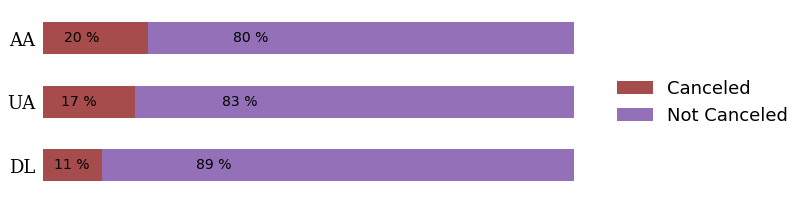

In [8]:
# Grouping data by count
df1=df.reset_index().groupby(['UniqueCarrier','Canceled']).agg({'index': 'count'})
# Converting count into percentage
df2= df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
# Coverting Canceled into text for data visualization
df2['Canceled']=df2['Canceled'].map({0:'Not Canceled',1:'Canceled'})
# Coverting grouped data into the format that needed for the given type of visualization
df3=pd.pivot_table(df2, index=['Canceled'], values=['index'], \
                   columns='UniqueCarrier',aggfunc='sum').T.reset_index().\
                   sort_values(by='Not Canceled',ascending=False)

# Plotting visualization
plt.style.use('ggplot')
ax=df3.plot.barh(stacked=True,color=['maroon', 'rebeccapurple'], alpha=.7,figsize=(10,3.5))
# Plotting text annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f} %'.format(width), (p.get_x()+.2*width, p.get_y()+.4*height),size=14)
# Plotting legends
ax.set_facecolor('white')
ax.get_xaxis().set_ticks([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_yticklabels(df3['UniqueCarrier'], size =18,family='serif', color='black')
leg=ax.legend(['Canceled', 'Not Canceled'], loc='best', \
          fontsize=10,bbox_to_anchor=(1, .7),prop={'size':18}) 
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')
ax.yaxis.grid(False)
plt.show()

Most cancelations from American Airline can be expected in April. Cancelations from the other airlines more or less equally distributed throughout the months. All airline companies are more likely to cancel flights in the morning and afternoon. 

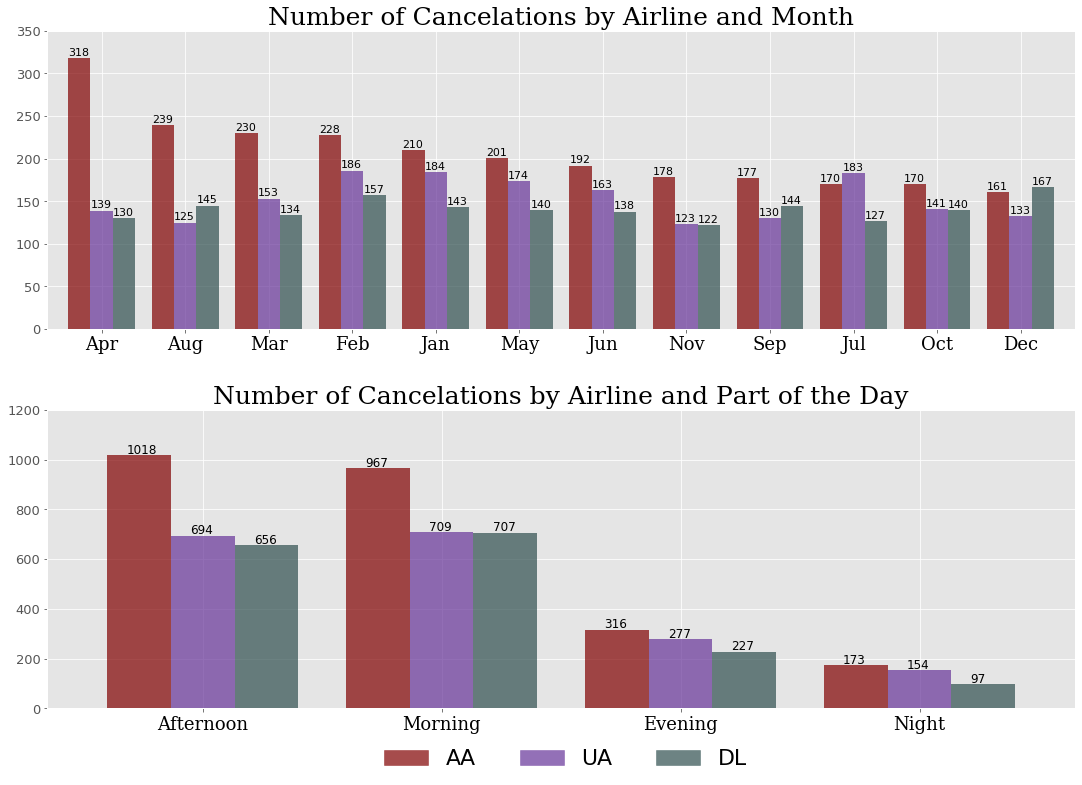

In [9]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=2, figsize=(15,10))
plt.tight_layout(h_pad=6)
# Organizing flights into a list of tuples to loop over
flights=[(x, y) for x in ['Month','DT_daypart'] \
        for y in ['Canceled']] 
# Organizing titles into a list to loop over
titles=['Month','Part of the Day']
# Looping over axes,flights, and titles 
for ax,flight,title in zip(axes.flat, flights, titles):
# Grouping data by count
    df1=pd.pivot_table(df, index=['UniqueCarrier'], values=flight[1], \
                   columns=flight[0],aggfunc='count').T.reset_index()\
                   .sort_values(by=['AA','UA'],ascending=False)
    # Plotting Data
    df1[['AA','UA','DL']].plot(kind='bar',
               color=['maroon','rebeccapurple','Darkslategrey'],fontsize=13, alpha=.7, ax=ax,width=.8)
    ax.set_xticklabels(df1[flight[0]],size =18,family='serif', \
                       color='black', rotation='horizontal')
    # Plotting text annotations
    if flight[0]=='Month':
        for i in ax.patches:
                ax.text( i.get_x(),i.get_height()+3, \
                '{:.0f}'.format(i.get_height()), fontsize=11)
        ax.set_ylim([0,350])
    else: 
        for i in ax.patches:
            ax.text( i.get_x()+.08,i.get_height()+7, \
                '{:.0f}'.format(i.get_height()), fontsize=12)
        ax.set_ylim([0,1200]) 
    # Plotting title and legends
    leg=ax.legend().set_visible(False) 
    ax.set_title("Number of Cancelations by Airline and "+ title, \
                 fontsize=25,family='serif',y=1.3)    
leg=ax.legend(['AA','UA','DL'],  ncol=3,loc='lower right', \
          fontsize=12,prop={'size':22},bbox_to_anchor=(.7, -.27))
leg.legendHandles[2].set_color('darkslategrey')
leg.legendHandles[1].set_color('rebeccapurple')
leg.legendHandles[0].set_color('maroon')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

Interestingly, the average departure delay time is inversely related to cancelations. Please see the chart below. That means that flights are rarely get canceled if they are delayed. Looking at the flight delay history might be an important factor in determining whether a flight would be canceled or not. 

Flights are also more likely to be canceled if the distance to the destination is larger. 


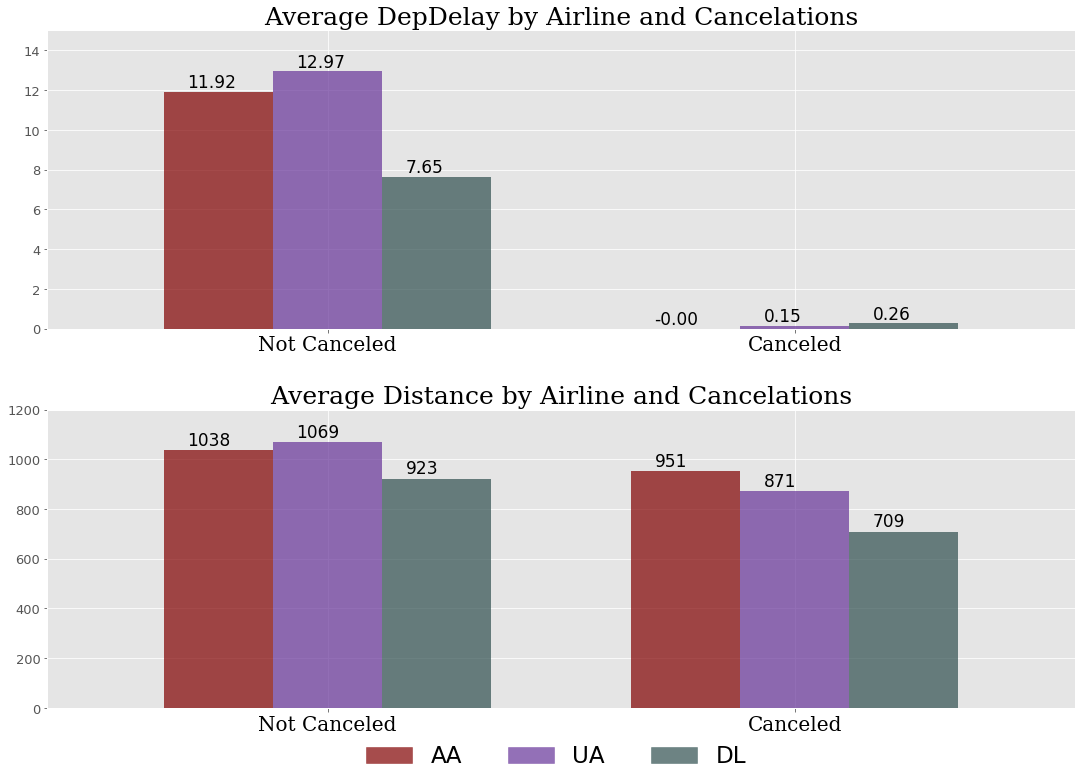

In [10]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=2, figsize=(15,10))
plt.tight_layout(h_pad=6)
# Organizing flights into a list of tuples to loop over
flights=[(x, y) for x in ['DepDelay','Distance'] \
        for y in ['Canceled']] 
# Organizing titles into a list to loop over
titles=['Average DepDelay','Average Distance']
# Looping over axes,flights, and titles 
for ax,flight,title in zip(axes.flat, flights, titles):
    # Grouping data by count
    df1=pd.pivot_table(df, index=['UniqueCarrier'], values=flight[0], \
                   columns=flight[1],aggfunc='mean').T.reset_index()\
                   .sort_values(by='AA',ascending=False)
    # Plotting data
    df1[['AA','UA','DL']].plot(kind='bar',
               color=['maroon','rebeccapurple','Darkslategrey'],fontsize=13,ax=ax,width=.7, alpha=.7)
    ax.set_xticklabels(['Not Canceled','Canceled'],size =20,family='serif', \
                       color='black', rotation='horizontal')
    if flight[0]=='DepDelay':
        for i in ax.patches:
                ax.text(i.get_x()+.05,i.get_height()+.2, \
                '{:.2f}'.format(i.get_height()), fontsize=17)
        ax.set_ylim([0,15])
    else: 
        for i in ax.patches:
            ax.text( i.get_x()+.05,i.get_height()+20, \
                '{:.0f}'.format(i.get_height()), fontsize=17)
        ax.set_ylim([0,1200])  
    leg=ax.legend().set_visible(False) 
    ax.set_title(title + ' by Airline and Cancelations', \
                 fontsize=25,family='serif',y=1.7) 
# Plotting title and legends
leg=ax.legend(['AA','UA','DL'],  ncol=3,loc='lower right', \
          fontsize=12,prop={'size':23},bbox_to_anchor=(.7, -.27))
leg.legendHandles[2].set_color('Darkslategrey')
leg.legendHandles[1].set_color('rebeccapurple')
leg.legendHandles[0].set_color('maroon')
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

### Part 3: Building the Model

For the model, I picked ensembles and logistic regression. The reason why I stopped on ensembles is because I have an unbalanced outcome, and ensembles work very well with synthetic minority synthetic oversampling techniques. In this case, however, the oversampling did not significantly improve my recall (only by 2 points) but it also decreased my precision. I decided not to proceed with oversampling model (not shown here). Instead, I calibrated the model that gave me the best precision and recall, which is the Ada Boost model. Calibration, actually, gave me the result similar to the result I got using the oversampling technique. I decided to keep calibrated and uncalibrated models for comparison. 

In [11]:
# looking at whether my outcome is unbalanced
df['Canceled'].value_counts(normalize=True)

0.000   0.833
1.000   0.167
Name: Canceled, dtype: float64

In [12]:
# Standardizing continuous features
from sklearn.preprocessing import StandardScaler
x=df[['DepDelay','Distance']]
X_norm =  StandardScaler().fit_transform(x);
df_stand_cont=pd.DataFrame(X_norm, columns=x.columns)

len(df_stand_cont)

5995

In [13]:
# Getting dummy variables of categorical features 
import patsy
df_c=df[['Month','UniqueCarrier','DT_daypart']]
X = patsy.dmatrix('~ C(Month)+C(UniqueCarrier)+C(DT_daypart)', df_c)
df_cat=pd.DataFrame(X, columns=X.design_info.column_names)
len(df_cat)

5995

In [14]:
# Combining dummy variables with standardized continuous features 
X = pd.concat([df_cat, df_stand_cont], axis=1)
y = df.Canceled
len(X)

5995

Random Forest Score:	0.934 ± 0.005
Ada Boost Score:	0.947 ± 0.006
Gradient Boosting Score:	0.954 ± 0.004
Logistic Regression Score:	0.603 ± 0.015

Feature Weights:


,Random Forest,Ada Boost,Gradient Boosting
DepDelay,0.944,0.480,0.705
Distance,0.026,0.320,0.160
C(Month)[T.Oct],0.013,0.020,0.026
C(UniqueCarrier)[T.DL],0.009,0.040,0.016
C(Month)[T.Nov],0.002,0.020,0.010
C(Month)[T.Mar],0.002,0.020,0.004
C(Month)[T.May],0.001,0.020,0.005
C(Month)[T.Jan],0.001,0.020,0.005
C(Month)[T.Dec],0.001,0.020,0.004
C(Month)[T.Jul],0.000,0.000,0.005


None


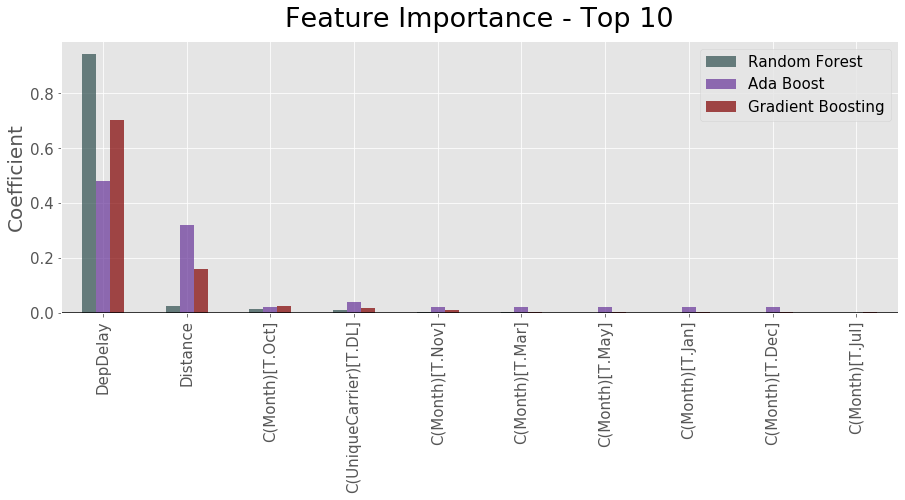

In [15]:
plt.style.use('ggplot')

# Breaking data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X,\
                                                    y,train_size=0.7,random_state=1,stratify=y)

# Defining my models and running them
rf = RandomForestClassifier(random_state=10,class_weight = 'balanced')
abc = AdaBoostClassifier(random_state=10)
gbc = GradientBoostingClassifier(random_state=10)
lg= LogisticRegression(random_state=10,class_weight='balanced')

# Choosing parameters for K fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=78)
# Defining scores for the models (accuracy is the default)
def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

# Printing the accuracy scores
score(rf,"Random Forest")
score(abc, "Ada Boost")
score(gbc, "Gradient Boosting")
score(lg,"Logistic Regression" )

# Fitting my traning sets
rf.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
lg.fit(X_train, y_train)

# Preparing feature weights for plotting
importances = pd.DataFrame(list(zip(gbc.feature_importances_,
                               abc.feature_importances_,
                               rf.feature_importances_,
                              )),
                           index=X_train.columns,
                           columns=['Random Forest',
                                    'Ada Boost',
                                    'Gradient Boosting',
                                   ]).sort_values('Random Forest',
                                                                 ascending=False)

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')

# Printing feature weights 
print (display(importances.head(30)))


# Plotting features weights
importances[0:10].plot(kind='bar', figsize=(15,5), color=['darkslategrey','rebeccapurple','maroon'], alpha=.7)


plt.title('Feature Importance - Top 10', fontsize = 27, y = 1.03, color='black')


plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

As we can see above, Gradient Boosting gave me the highest accuracy score (accuracy =.957), but Ada Boost gave me a better combination of precision and recall (not shown here) so I picked the Ada Boost (accuracy = .947) 

Also, departure delay is the most important predictor in the model followed by distance. My recommendation is to look at historical data of departure delays for each airline and part of teh day and inform customers accordingly. For example, flights that are historically more likely to be delayed are also less likely to be canceled. 

In [16]:
# Predicting probs for the test sample
y_pred_test=abc.predict(X_test)
# Estimating test accuracy
test_acc = accuracy_score(y_true=y_test, y_pred=abc.predict(X_test))
# Estimating confusion matrix
matrix_clf = np.array(confusion_matrix(y_test, abc.predict(X_test)))
# Preparing confusion matrix for plotting
confusion_clf = pd.DataFrame(matrix_clf, index=['Not Canceled','Canceled'],\
                     columns=['Not  Canceled','Canceled'])
print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred_test))

Test Accuracy: 94.89%

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      1499
         1.0       0.78      0.97      0.86       300

    accuracy                           0.95      1799
   macro avg       0.89      0.96      0.92      1799
weighted avg       0.96      0.95      0.95      1799



I got a very good recall, but my precision is on a low side. It does, however, look like a decent predictive model. I proceeded with calibration to see if I can further improve my model.  

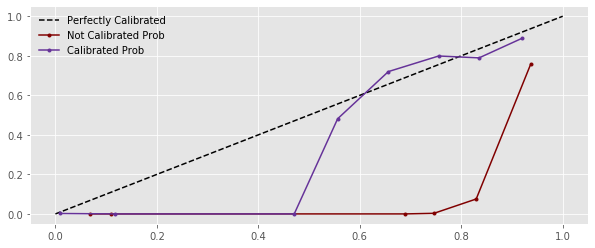

In [22]:

plt.style.use('ggplot')

plt.figure(figsize=(10,4))
 
# Predicting uncalibrated probabilities
def uncalibrated(X_train, X_test, y_train):
    # Fitting the model
    abc = AdaBoostClassifier(random_state=10)
    abc.fit(X_train, y_train)
    # Predicting probabilities
    return abc.predict_proba(X_test)[:, 1]

 
# Predicting calibrated probabilities
def calibrated(X_train, X_test, y_train):
    # Defining model
    abc = AdaBoostClassifier(random_state=10)
    # Defining and fitting calibration model
    calibrated = CalibratedClassifierCV(abc, 
                                        cv=5)
    calibrated.fit(X_train, y_train)
    # Predicting probabilities
    return calibrated.predict_proba(X_test)[:, 1]
# Uncalibrated predictions
yhat_uncalibrated = uncalibrated(X_train, X_test, y_train)
# Calibrated predictions
yhat_calibrated = calibrated(X_train, X_test, y_train)
# Reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, yhat_calibrated, n_bins=10)
# Plotting perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# Plotting model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', color='maroon')
plt.plot(mpv_calibrated, fop_calibrated, marker='.', color='rebeccapurple')
plt.legend(['Perfectly Calibrated','Not Calibrated Prob','Calibrated Prob'], fontsize=10,frameon=False)
plt.show()

As we can see above, calibration seemed to help improve the recall of canceled flights.

In [440]:
# Saving calibrated model
model = AdaBoostClassifier(random_state=10)
calibrated = CalibratedClassifierCV(model,  cv=5)
calibrated.fit(X_train, y_train)
saved_model = pickle.dumps(calibrated)


In [441]:
# Predicting probs of calibrated model
y_pred_test=calibrated.predict(X_test)
# Estimating test accuracy of calibrated model
test_acc = accuracy_score(y_true=y_test, y_pred=calibrated.predict(X_test))
# Estimating confusion matrix
matrix_clf = np.array(confusion_matrix(y_test, calibrated.predict(X_test)))
# Preparing confusion matrix for plotting
confusion_clf_cal = pd.DataFrame(matrix_clf, index=['Not Canceled','Canceled'],\
                     columns=['Not Canceled','Canceled'])
print('Test Accuracy of Calibrated Model: %.2f%%' % (100 * test_acc))
print ('')
print (classification_report(y_test, y_pred_test))

Test Accuracy of Calibrated Model: 94.66%

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1499
         1.0       0.76      0.99      0.86       300

    accuracy                           0.95      1799
   macro avg       0.88      0.96      0.91      1799
weighted avg       0.96      0.95      0.95      1799



Calibration seemed to improve recall by 2 points, although it did decrease precision by 2 points. It is a very similar result that I observed with oversampling.  In any case, I kept the model for comparison. 

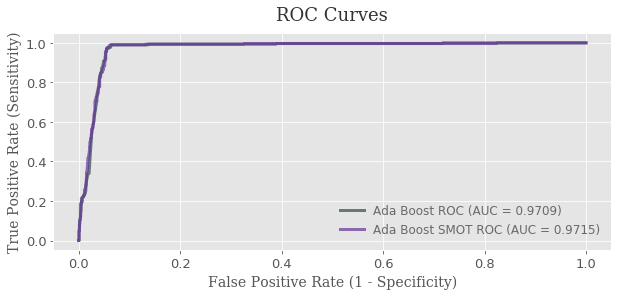

In [385]:
# Plotting AUC curve for calibrated vs uncalibrated model
plt.style.use('ggplot')

plt.figure(figsize=(10,4))
# Predicting probabilities of both models 
y_pred_clf = abc.predict_proba(X_test)[:,1]
y_pred_clf_cal = calibrated.predict_proba(X_test)[:,1]

# Calculating roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_clf)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,y_pred_clf_cal)

# Calculating AUCs
ROC_AUC = auc(fpr, tpr)
ROC_AUC1 = auc(fpr1, tpr1)

# Plotting roc curves
plt.plot(fpr, tpr, label='Ada Boost ROC (AUC = %0.4f)' % ROC_AUC,color='darkslategrey', linewidth=3, alpha=.7)
plt.plot(fpr1, tpr1, label='Ada Boost SMOT ROC (AUC = %0.4f)' % ROC_AUC1, color='rebeccapurple',linewidth=3, alpha=.7)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14,family='serif')
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14,family='serif')

# Plotting legends and titles
l=plt.legend(loc='lower right', fontsize=12,bbox_to_anchor=(1, 0.015),frameon=False)
for text in l.get_texts():
    text.set_color("dimgray")

plt.title('ROC Curves', color="black", alpha=0.8,fontsize=18, y=1.03,family='serif')
plt.show()


Calibration did not really improve AUC score, but, again, it did improve recall of canceled flights, as seen below. 

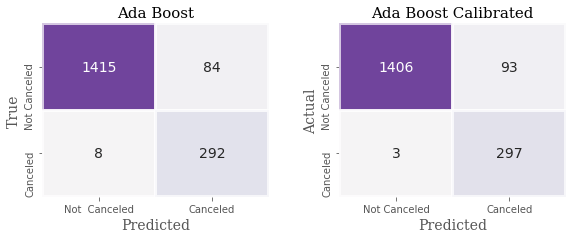

In [386]:
# Plotting confusion matrices for uncalibrated vs calibrated model
plt.style.use(['ggplot'])

fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.tight_layout(w_pad=4.0)


sns.heatmap(confusion_clf, annot=True, annot_kws={"size": 14},cmap="Purples",fmt='g', cbar=False,linewidths=2,ax=axes[0], alpha=.7)
axes[0].set_ylabel('True', fontsize=14,family='serif')
axes[0].set_xlabel('Predicted', fontsize=14,family='serif')
axes[0].set_title("Ada Boost", fontsize=15, y=1.05,family='serif')

sns.heatmap(confusion_clf_cal, annot=True, annot_kws={"size": 14},cmap='Purples',fmt='g', cbar=False,linewidths=2,ax=axes[1], alpha=.7)
axes[1].set_ylabel('Actual', fontsize=14,family='serif')
axes[1].set_xlabel('Predicted', fontsize=14,family='serif')
axes[1].set_title("Ada Boost Calibrated", fontsize=15, y=1.05,family='serif')

plt.show()

As we can see, both models do a good job. Calibrated model is better on recall of canceled flights, but is a bit lower on precision. Because, it is low on precision, it identifies more not-canceled flights as canceled. If recall of canceled flights is more important for business, I would use the calibrated model. Otherwise, uncalibrated model would do a good job too. 

### Part 4: Building the Function that Uses the Model Output to Predict Whether a Future Fight will be Canceled.

Due to time shortage, I will abstain from throwing exception errors in my function. 

In [353]:

def predict():
    # Listing all data inputs
    month = int(input('Enter month in digits 1 to 12: '))
    dep_time = int(input('Enter approximate departure time in digits: '))
    dep_delay=int(input('Enter departure delay in minutes: '))
    distance=int(input('Enter distance: '))
    airline=str(input('Enter airline: '))
    # Loading data
    data=pd.read_csv('FlightDelays_Data_3.0.csv')
    # Selecting data that needed for the function and dropping missing cases
    df=data[['Month','DepartureTime','DepDelay','Distance','UniqueCarrier']].dropna()
    # Creating dictionary for new data to add
    new_data={'Month': month,'DepartureTime': dep_time, 'DepDelay': dep_delay,'Distance':distance,'UniqueCarrier':airline}
    # Appending new data to the selected data set
    df_new=df.append(new_data,ignore_index=True,sort=False)
    # Making a copy of new data frame
    df_updated=df_new.copy()
    # Adjusting time (converting into 4 digits string) to convert it into day parts
    def adjust_time(time):
        if len(str(time))==2:return '24'+str(time)
        elif len(str(time))==3:return '0'+str(time)
        else: return str(time)
    df_updated['DepartureTime']=df_updated['DepartureTime'].map(adjust_time)
    # Converting arrival time to day parts
    def get_day_part(dep_time):
        if 6 < dep_time <= 12: return "Morning"
        elif 12 < dep_time <= 18: return "Afternoon" 
        elif 18 < dep_time <= 24: return "Evening"
        else: return "Night"
    df_updated['DT_daypart']=df_updated['DepartureTime'].map(lambda x: int(x[:2])).map(get_day_part)
    # Converting month into string 
    df_updated["Month"]= df_updated["Month"].astype(str)
    # Standardizing continuous features
    x=df_updated[['DepDelay','Distance']]
    X_norm =  StandardScaler().fit_transform(x);
    df_stand_cont=pd.DataFrame(X_norm, columns=x.columns)
    # Getting dummy variables of categorical features 
    df_c=df_updated[['Month','UniqueCarrier','DT_daypart']]
    X_cat = patsy.dmatrix('~ C(Month)+C(UniqueCarrier)+C(DT_daypart)', df_c)
    df_cat=pd.DataFrame(X_cat, columns=X_cat.design_info.column_names)
    X = pd.concat([df_cat, df_stand_cont], axis=1)
    # Loading saved model
    model = pickle.loads(saved_model)
    # Attaching predicted outcome to the original data frame
    df_new['predicted_outcome']=model.predict(X)
    # Attaching predicted probs to the original data frame
    df_new['predicted_prob'] = model.predict_proba(X)[:,1:]*100
    # Getting predicted outcome for new data
    predicted_outcome=df_new['predicted_outcome'].loc[(df_new['Month']==month)&(df_new['DepartureTime']==dep_time)&\
      (df_new['DepDelay']==dep_delay) &(df_new['Distance']==distance)&\
           (df_new['UniqueCarrier']==airline)]
    # Getting predicted probs for new data
    predicted_proba=df_new['predicted_prob'].loc[(df_new['Month']==month)&(df_new['DepartureTime']==dep_time)&\
      (df_new['DepDelay']==dep_delay) &(df_new['Distance']==distance)&\
           (df_new['UniqueCarrier']==airline)]
    print ()
    # Printing predicted outcome and probs
    if predicted_outcome.values[0]==1:
        print ('The flight is at high risk of being canceled - {0:.0f}%'.format(predicted_proba.values[0]))
    else:
        print ('The flight is at low risk of being canceled - {0:.0f}%'.format(predicted_proba.values[0]))          
    return 

In [354]:
predict()

Enter month in digits 1 to 12: 1
Enter approximate departure time in digits: 234
Enter departure delay in minutes: 0
Enter distance: 345
Enter airline: UA

The flight is at high risk of being canceled - 81%


In [420]:
predict()

Enter month in digits 1 to 12: 1
Enter approximate departure time in digits: 234
Enter departure delay in minutes: 15
Enter distance: 345
Enter airline: UA

The flight is at low risk of being canceled - 1%


### What I would do differently given more time:

What I would do differently given more time:

1) I would grid search for best parameters in my model. 
2) I would try various synthetic oversampling techniques (not just one).
3) I would throw some exception errors in my function. 
4) I would do better on data visualization

